<a href="https://colab.research.google.com/github/raagzz/tutorials/blob/main/PyTorch/01_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![link text](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn # contains PyTorch's building blocks for neural nets
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

# 1. Data (preparing and loading)

We'll use linear regression to create the data with **known** parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [3]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step =0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Split data into training and test sets

- Training set: The model learns from this data. (60-80%)
- Validation set: The model gets tuned on this data (10-20%)
- Testing set: The model gets evaluated on this data to test what it has learnt. (10-20%)


In [4]:
train_split = int(0.8 * len(X))

# 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

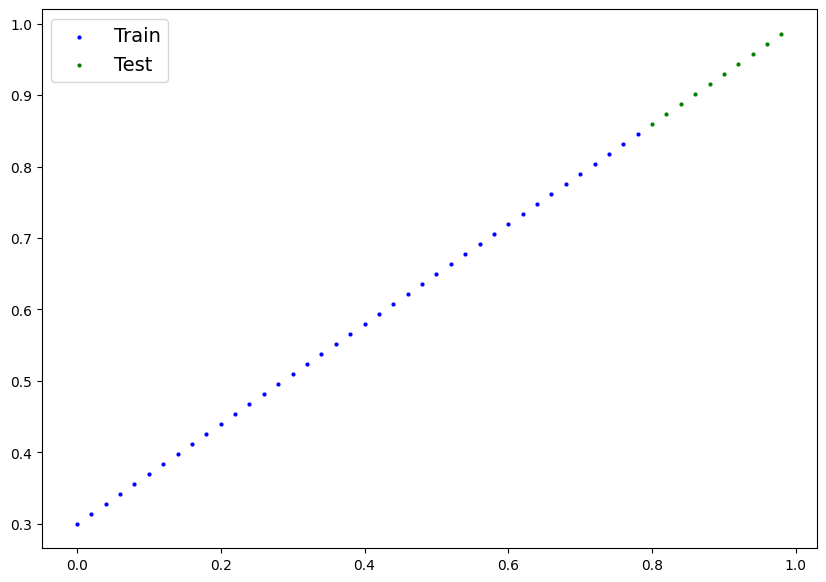

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """

    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c='b', s=4, label="Train")
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='predictions')

    plt.legend(prop={'size': 14})

plot_predictions()

# 2. Build model

In [6]:
# Create a Linear Regression model class

class LinearRegression(nn.Module): # almost everything in PyTorch is nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float),
                                    requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                                 requires_grad=True)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # this is linear regression

## PyTorch model building essentials

PyTorch has 4 essential modules to create almost any kind of neural networks.

1. `torch.nn` contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way)

2. `torch.nn.Parameter` Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as **autograd**.

3. `torch.nn.Module` Contains the larger building blocks (layers). If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented.

4. `torch.optim` Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

5. `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within `nn.Module`.

![link text](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)

## Checking the contents of a PyTorch model

In [7]:
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegression()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using `torch.inference_mode()`

In [9]:
# Make predictions with model
with torch.inference_mode(): # in older code, might also see torch.no_grad()
    y_preds = model_0(X_test)

> `torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the `forward()` method) faster.

In [10]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


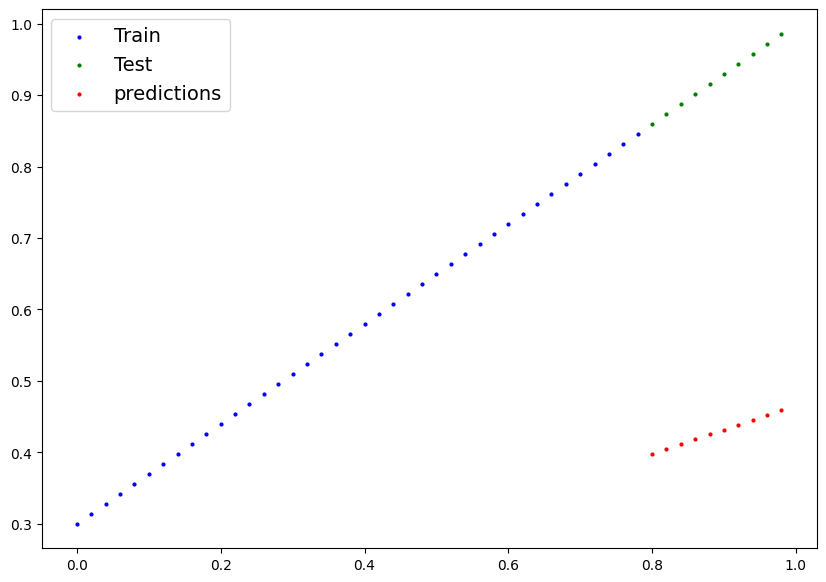

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

# 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters to be something that better represents the data.

## Creating a loss function and optimizer in PyTorch

- **Loss function:** Measure how wrong your model's predictions are compared to the ground truth. Lower the better.

- **Optimizer:** Tells your model how to update its internal parameters to best lower the loss.

![link text](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)

In [13]:
# Create the loss function
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

## Creating an optimization loop in PyTorch


![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

In [14]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values =[]
epoch_count  =[]

for epoch in range(epochs):
    ### Training loop ###

    model_0.train() # Put model in training mode (default state)

    y_pred = model_0(X_train) # 1. Forward pass on train data
    loss = loss_fn(y_pred, y_train) # 2. Calculate the loss
    optimizer.zero_grad() # 3. Zero grad of the optimizer
    loss.backward() # 4. Loss backwards
    optimizer.step() # 5. Progress the optimizer

    ### Testing loop ###

    model_0.eval() # Put the model in evaluation mode

    with torch.inference_mode():
        test_pred = model_0(X_test) # 1. Forward pass on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # 2. Calculate loss on test data

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")


Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


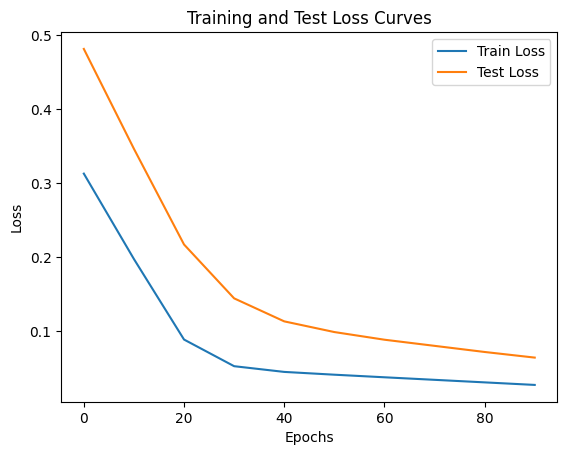

In [15]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# 4. Making predictions with a trained PyTorch model (inference)



In [17]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

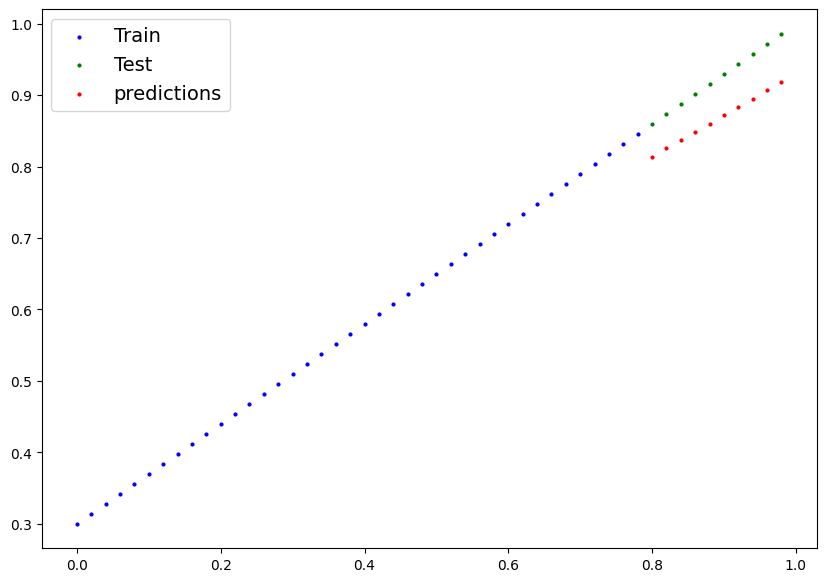

In [18]:
plot_predictions(predictions=y_preds)

# 5. Saving and loading a PyTorch model


## Saving a PyTorch model's `state_dict()`

The recommended way for saving and loading a model for inference  is by saving and loading a model's state_dict().

> It's common convention for PyTorch saved models or objects to end with .pt or .pth, like saved_model_01.pth.

In [19]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [20]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Dec  8 16:17 models/01_pytorch_workflow_model_0.pth


## Loading a saved PyTorch model's `state_dict()`

> The disadvantage of the approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
Because of this, your code can break in various ways when used in other projects or after refactors.

In [21]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegression()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-21-d2cfce01f24e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [22]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [23]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together

In [24]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cu121'

In [25]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 6.1 Data

In [26]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

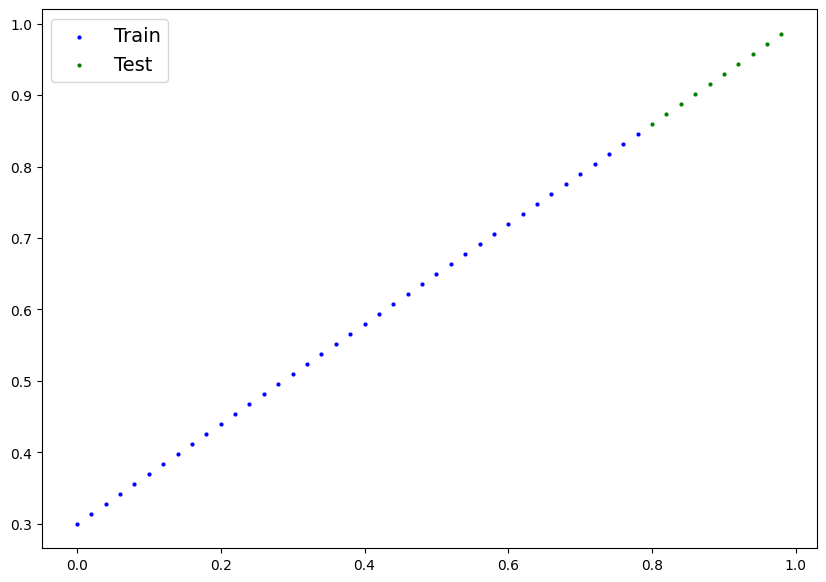

In [28]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch linear model
We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using nn.Parameter(), we'll use nn.Linear(in_features, out_features) to do it for us.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-regression-model-with-nn-Parameter-and-nn-Linear-compared.png)

In [29]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [30]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [31]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training

In [32]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [33]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    y_pred = model_1(X_train) # 1. Forward pass
    loss = loss_fn(y_pred, y_train) # 2. Calculate loss
    optimizer.zero_grad() # 3. Zero grad optimizer
    loss.backward() # 4. Loss backward
    optimizer.step() # 5. Step the optimizer

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)

    with torch.inference_mode():
        test_pred = model_1(X_test) # 1. Forward pass
        test_loss = loss_fn(test_pred, y_test) # 2. Calculate the loss

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [34]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 6.4 Making predictions

In [35]:
model_1.eval() # Turn model into evaluation mode

with torch.inference_mode(): # Make predictions on the test data
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

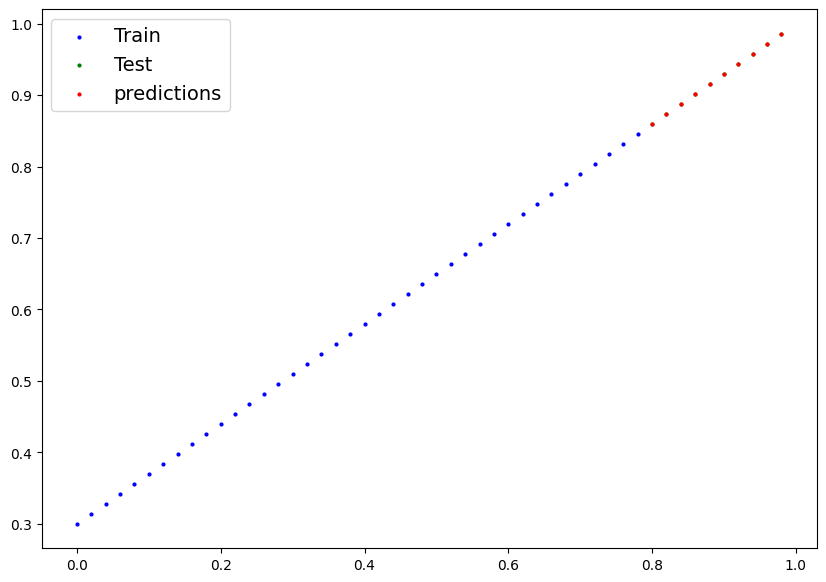

In [36]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

## 6.5 Saving and loading a model

In [37]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [38]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


<ipython-input-38-c4e3cba863db>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [39]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

# Exercises

In [40]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

1. Create a straight line dataset using the linear regression formula (weight * X + bias).
Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
Split the data into 80% training, 20% testing.
Plot the training and testing data so it becomes visual.

In [42]:
weight = 0.3
bias =0.9

X = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y = weight * X + bias
print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


In [43]:
train_split = int(len(X) * 0.8)
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(80, 80, 20, 20)

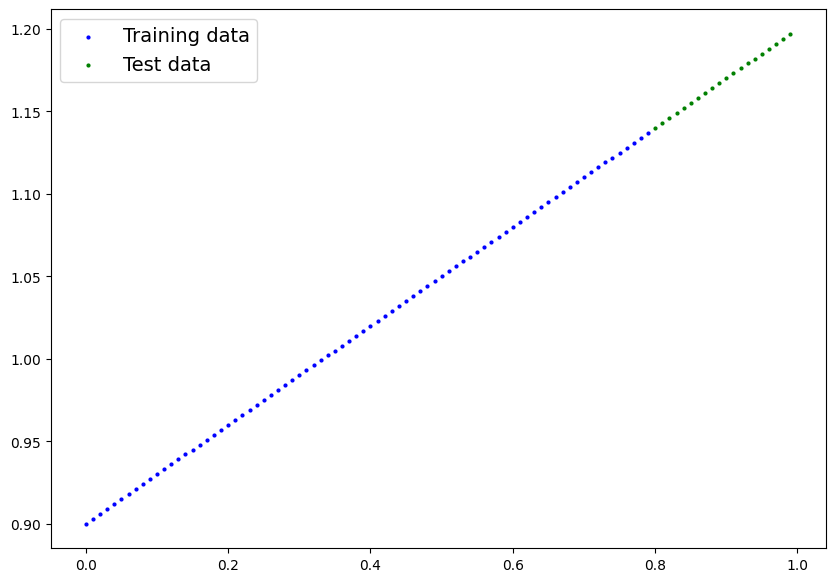

In [44]:
def plot_predictions(train_data = X_train,
                 train_labels = y_train,
                 test_data = X_test,
                 test_labels = y_test,
                 predictions = None):
  plt.figure(figsize = (10,7))
  plt.scatter(train_data,train_labels,c = 'b',s = 4,label = "Training data")
  plt.scatter(test_data,test_labels,c = 'g',s = 4,label = "Test data")

  if predictions is not None:
    plt.scatter(test_data,predictions,c = 'r',s = 4,label = "Predictions")
  plt.legend(prop = {"size" : 14})
plot_predictions()


2. Build a PyTorch model by subclassing nn.Module.
- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its state_dict().

In [45]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)
  def forward(self,x : torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1,model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [46]:
model_1.to(device)
list(model_1.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.

In [47]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [48]:
torch.manual_seed(42)

epochs = 300

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training

    model_1.train()
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    if epoch % 20 == 0:
        model_1.eval()
        with torch.inference_mode():
            y_preds = model_1(X_test)
            test_loss = loss_fn(y_preds,y_test)

            print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")


Epoch: 0 | Train loss: 0.128 | Test loss: 0.337
Epoch: 20 | Train loss: 0.082 | Test loss: 0.218
Epoch: 40 | Train loss: 0.072 | Test loss: 0.175
Epoch: 60 | Train loss: 0.065 | Test loss: 0.153
Epoch: 80 | Train loss: 0.058 | Test loss: 0.137
Epoch: 100 | Train loss: 0.051 | Test loss: 0.121
Epoch: 120 | Train loss: 0.045 | Test loss: 0.104
Epoch: 140 | Train loss: 0.038 | Test loss: 0.088
Epoch: 160 | Train loss: 0.031 | Test loss: 0.072
Epoch: 180 | Train loss: 0.024 | Test loss: 0.056
Epoch: 200 | Train loss: 0.017 | Test loss: 0.040
Epoch: 220 | Train loss: 0.010 | Test loss: 0.024
Epoch: 240 | Train loss: 0.003 | Test loss: 0.007
Epoch: 260 | Train loss: 0.008 | Test loss: 0.007
Epoch: 280 | Train loss: 0.008 | Test loss: 0.007


4. Make predictions with the trained model on the test data.
- Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [49]:
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[1.1333],
        [1.1363],
        [1.1393],
        [1.1423],
        [1.1454],
        [1.1484],
        [1.1514],
        [1.1545],
        [1.1575],
        [1.1605],
        [1.1635],
        [1.1666],
        [1.1696],
        [1.1726],
        [1.1757],
        [1.1787],
        [1.1817],
        [1.1847],
        [1.1878],
        [1.1908]], device='cuda:0')

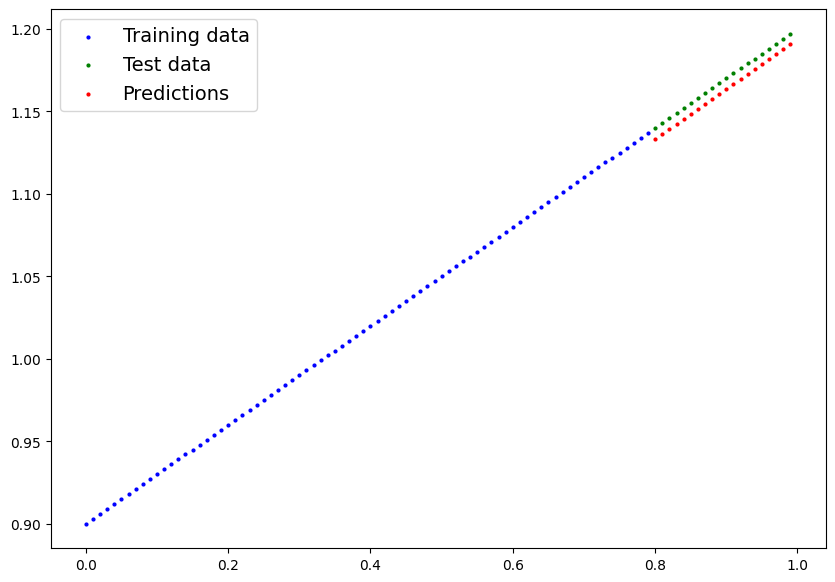

In [50]:
plot_predictions(predictions = y_preds.cpu())

5. Save your trained model's state_dict() to file.
- Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [51]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,exist_ok = True)

MODEL_NAME = "01_pytorch_model"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),f = MODEL_SAVE_PATH)

Saving model to models/01_pytorch_model


In [52]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.to(device)

<ipython-input-52-9d5aad8aaeb9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [53]:
y_preds_new = loaded_model(X_test)
y_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [54]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3028]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])

- Read: [Python OOP](https://realpython.com/python3-object-oriented-programming/)
- Read [What is torch.nn, really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard for a deeper understanding of how one of the most important modules in PyTorch works.
- Spend 10-minutes scrolling through and checking out the [PyTorch documentation cheatsheet](https://pytorch.org/tutorials/beginner/ptcheat.html) for all of the different PyTorch modules you might come across.
- Spend 10-minutes reading the [loading and saving documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) on the PyTorch website to become more familiar with the different saving and loading options in PyTorch.